# Work with SQL

For most tabularly structured data, such as spreadsheets or CSVs, we can fit them into a database that implements Structured Query Language, or SQL.

The Pandas `DataFrame` shares many similarities with SQL data tables in terms of functionalities, but it is bound to the application layer, which requires a properly configured Python runtime to function. On the other hand, SQL databases usually serve through their independent layer, thus not affected by application crashes on their own.

The Pandas library implements a set of interfaces to work with SQL databases (through an underlying abstraction library called `sqlalchemy`) to recognize the flexibility and strengths (such as better data persistence, among others) these databases can provide to work with data, especially for those that prefer a declarative language.

Among all the choices, SQLite is a fascinating one. It is a file-based SQL database solution with astonishing performance, near-zero configuration and maintenance, and comprehensive features. While it cannot compete with dedicated server-side SQL database solutions such as MySQL, Postgres, SQL Server, and others in a typical server/client application architecture, it excels at single-machine use cases. Usually, it performs faster than server-side solutions since there would be no network latency. It is widely available in UNIX/Linux-based systems due to its tiny footprints, such as in iOS and Android.

Since we don't have to worry about database configurations, it's perfect for quick demonstrations and ad-hoc data queries and persistence.

## Filter data

Recall the first recipe from [`locussdk-collab`](https://github.com/EQWorks/locussdk-collab):

In [1]:
# recipe from locussdk-collab
from locussdk import get_avail_poi_lists
from pandas import DataFrame


def search_avail_poi_lists(name: str = '', **kwargs) -> DataFrame:
    '''Search available POI lists based on locussdk.get_avail_poi_lists().

    Args:
        name (str): name to search in the available POI lists.
        **kwargs:
            All locussdk.get_avail_poi_lists() supported arguments.
            All pandas.Series.str.contains() supported arguments.

    Returns:
        pandas.DataFrame that contain the search resulting POI lists.

    Examples:
    >>> search_avail_poi_lists('pizza')
                name  poi_list_id whitelabelid customerid
    67       Bostonpizza           71         None       None
    113       Pizzapizza          118         None       None
    116       Pizzaville          121         None       None
    117     Pizzadelight          122         None       None
    139        Pizzanova          144         None       None
    157         Pizzahut          162         None       None
    175  Neworleanspizza          180         None       None
    327         241Pizza          332         None       None
    422       Royalpizza          427         None       None
    450       Ginospizza          455         None       None
    730     Mammas Pizza          735         None       None
    786      Doublepizza          791         None       None
    '''
    # build parameters we want to pass into get_avail_poi_lists()
    params = {'list_type': 'global'}  # default search in global
    for k in ['list_type', 'whitelabel', 'customer']:
        if v := kwargs.pop(k, None):
            params[k] = v

    lists = get_avail_poi_lists(**params)

    # return the full available POI lists if no search string given
    if not name:
        return lists

    return lists[lists['name'].str.contains(name, **kwargs)]

In [2]:
search_avail_poi_lists(name='pizza', case=False).reset_index(drop=True)

,name,poi_list_id,whitelabelid,customerid
0,Bostonpizza,71,None,None
1,Pizzapizza,118,None,None
2,Pizzaville,121,None,None
3,Pizzadelight,122,None,None
4,Pizzanova,144,None,None
5,Pizzahut,162,None,None
6,Neworleanspizza,180,None,None
7,241Pizza,332,None,None
8,Royalpizza,427,None,None
9,Ginospizza,455,None,None


We can easily recreate this using the SQL `WHERE` syntax.

First, let's load all global POI lists into a SQLite data table:

In [3]:
all_lists = get_avail_poi_lists('global')
all_lists

,name,poi_list_id,whitelabelid,customerid
0,Second Cup Canada,2,None,None
1,McDonalds,3,None,None
2,Tim Hortons,4,None,None
3,Xtracash,7,None,None
4,Overwaiteafoods,8,None,None
...,...,...,...,...
837,WMG - Subway,845,None,None
838,5Buds Cannabis,1431,None,None
839,BC Medi Chronic,1432,None,None
840,Beleave,1435,None,None


Since SQLite is so omnipresent, Python even has this as a part of its standard built-in library:

In [24]:
# SQLite is so omnipresent that Python has this as a part of its standard built-in library
import sqlite3 as sql

# define our DB file name
db = 'global_poi_lists.db'

In [25]:
# write it into the DB table `poi_lists`
with sql.connect(db) as con:
    all_lists.to_sql('poi_lists', con=con, if_exists='replace', index=False)

The database file:

![db file](https://user-images.githubusercontent.com/2837532/119175085-67a89080-ba37-11eb-8bf8-6ba7c3c9192e.png)

Now let's query the database table we populated just now with the same search condition as the recipe version does through a simple SQL query:

```sql
SELECT *
FROM poi_lists
WHERE name LIKE '%pizza%'
    OR name LIKE '%domino%';
```

In [26]:
import pandas as pd

query = '''
    SELECT *
    FROM poi_lists
    WHERE name LIKE '%pizza%'
        OR name LIKE '%domino%';
'''

with sql.connect(db) as con:
    # read it out
    pizzas_db = pd.read_sql(query, con=con)

pizzas_db

,name,poi_list_id,whitelabelid,customerid
0,Bostonpizza,71,None,None
1,Pizzapizza,118,None,None
2,Pizzaville,121,None,None
3,Pizzadelight,122,None,None
4,Pizzanova,144,None,None
5,Pizzahut,162,None,None
6,Neworleanspizza,180,None,None
7,241Pizza,332,None,None
8,Royalpizza,427,None,None
9,Ginospizza,455,None,None


## Joins

For those who have a taste for declarative languages, SQL is often on the top list; and among SQL syntax, its users often consider the `JOIN` statements the most elegant.

In relational databases such as most SQL implementations, data tables are often [_normalized_](https://en.wikipedia.org/wiki/Database_normalization). In order to make association between tables, we can utilize the `JOIN` statements. This is conceptually similar to Pandas' `merge()` function.

Let's begin by populating another data table `pois` from the POI lists we have retrieved. For `DataFrame`s that carry the same columns, we can simply append them all into the same table:

In [27]:
import locussdk as locus

# load POIs into a DB
with sql.connect(db) as con:
    for poi_list in pizzas_db.itertuples():
        pois = locus.get_pois(poi_list.poi_list_id)
        pois['list_id'] = poi_list.poi_list_id  # add a column for association through JOIN
        # persist POIs into sqlite
        pois.to_sql(
            'pois',
            if_exists='append',
            con=con,
            index=False,
        )

###### Quick verifications using a filter on all `region = ON`:

In [28]:
# filter by region == 'ON', like in 09
with sql.connect(db) as con:
    pizzas_on = pd.read_sql(
        sql='''
            SELECT *
            FROM pois
            WHERE region = 'ON';
        ''',
        con=con,
    )

pizzas_on

,id,name,city,region,postalCode,country,addressLabel,lat,lon,coords,chainId,list_id
0,32943,Bostonpizza - Conroy,Ottawa,ON,K1G 6C1,CA,"2980 Conroy Road,Ottawa,ON,K1G 6C1, Canada",45.382767,-75.630243,"45.3827671, -75.6302429",70,71
1,32944,Bostonpizza - St Laurent,Ottawa,ON,K1K 3B1,CA,"1055 St. Laurent Blvd.,Ottawa,ON,K1K 3B1, Canada",45.427042,-75.638414,"45.4270421, -75.638414",70,71
2,32945,Bostonpizza - Orleans,Orleans,ON,K1W 1K9,CA,"3884 Innes Road,Orleans,ON,K1W 1K9, Canada",45.453038,-75.510222,"45.4530377, -75.5102222",70,71
3,32946,Bostonpizza - Carling,Ottawa,ON,K2A 1C5,CA,"1640 Carling Avenue,Ottawa,ON,K2A 1C5, Canada",45.379562,-75.748339,"45.3795624, -75.7483389",70,71
4,32947,Bostonpizza - Hunt Club,Nepean,ON,K2G 5W5,CA,"521 West Hunt Club Road,Nepean,ON,K2G 5W5, Canada",45.334702,-75.725216,"45.3347017, -75.7252156",70,71
...,...,...,...,...,...,...,...,...,...,...,...,...
1178,122652,Dominos,Sault Ste Marie,ON,P6B4H9,CA,"317 Northern Avenue E Suite 1,Sault Ste Marie,...",46.533837,-84.320483,"46.5338369, -84.3204835",794,795
1179,122653,Dominos,Thunder Bay,ON,P7B1K3,CA,"863 Red River Road,Thunder Bay,ON,P7B1K3, Canada",48.446277,-89.249380,"48.4462766, -89.2493799",794,795
1180,122654,Dominos,Thunder Bay,ON,P7C5N3,CA,"772 James Street North,Thunder Bay,ON,P7C5N3, ...",48.399841,-89.278503,"48.3998407, -89.2785028",794,795
1181,122655,Dominos,Fort Frances,ON,P9A1G8,CA,"283 Scott ST,Fort Frances,ON,P9A1G8, Canada",48.609850,-93.396161,"48.6098502, -93.3961607",794,795


Or see a total count of POIs through the underlying `sqlite3` interface, which returns a Python `tuple` instead of a Pandas `DataFrame`:

In [29]:
with sql.connect(db) as con:
    print(con.execute('SELECT COUNT(*) FROM pois;').fetchone())

(2014,)


Notice how "Bostonpizza", and potentially others may have a per-POI variation of naming from the brand name. This is where we can utilize an `INNER JOIN` between the `pois` and `poi_lists` data tables to pin down on a definitive brand name:

In [30]:
with sql.connect(db) as con:
    pizzas_on = pd.read_sql(
        sql='''
            -- this is a SQL comment
            -- we will also leverage SELECT to only cherry-pick the columns we need
            SELECT pois.id, list.name, pois.city, pois.region
            FROM pois
            -- the INNER JOIN <table> ON <condition> syntax
            INNER JOIN poi_lists AS list
                ON pois.list_id = list.poi_list_id
            WHERE pois.region = 'ON';
        ''',
        con=con,
    )

pizzas_on

,id,name,city,region
0,32943,Bostonpizza,Ottawa,ON
1,32944,Bostonpizza,Ottawa,ON
2,32945,Bostonpizza,Orleans,ON
3,32946,Bostonpizza,Ottawa,ON
4,32947,Bostonpizza,Nepean,ON
...,...,...,...,...
1178,122652,Dominos,Sault Ste Marie,ON
1179,122653,Dominos,Thunder Bay,ON
1180,122654,Dominos,Thunder Bay,ON
1181,122655,Dominos,Fort Frances,ON


To achieve similar effect in Pandas, we would utilize the [Pandas `merge()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html#pandas.merge) (or the [`DataFrame.merge()` method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)) as mentioned earlier. Conceptually:

```python
joined_df = pd.merge(list_df, pois_df, on='list_id')
```

## Aggregations

We can also aggregate the sum of shops through `GROUP BY`:

In [31]:
# get some aggregated stats using SQL
with sql.connect(db) as con:
    # number of shops by brand (list_id) and by city + region
    by_city_chain = pd.read_sql(
        sql='''
            SELECT pois.list_id, list.name, pois.city, pois.region, COUNT(*) AS shops
            FROM pois
            INNER JOIN poi_lists AS list
                ON pois.list_id = list.poi_list_id
            -- reflects positionally by the order of SELECT columns
            GROUP BY 1, 2, 3, 4;
        ''',
        con=con,
    )
    # by brand and region
    by_region_chain = pd.read_sql(
        sql='''
            SELECT pois.list_id, list.name, pois.region, COUNT(*) AS shops
            FROM pois
            INNER JOIN poi_lists AS list
                ON pois.list_id = list.poi_list_id
            GROUP BY 1, 2, 3;
        ''',
        con=con,
    )
    # by brand
    by_chain = pd.read_sql(
        sql='''
            SELECT pois.list_id, list.name, COUNT(*) AS shops
            FROM pois
            INNER JOIN poi_lists AS list
                ON pois.list_id = list.poi_list_id
            GROUP BY 1, 2;
        ''',
        con=con,
    )

In [32]:
by_city_chain

,list_id,name,city,region,shops
0,71,Bostonpizza,Abbotsford,BC,2
1,71,Bostonpizza,Airdrie,AB,1
2,71,Bostonpizza,Ajax,ON,1
3,71,Bostonpizza,Aldergrove,BC,1
4,71,Bostonpizza,Alliston,ON,1
...,...,...,...,...,...
1082,795,Dominos,Winnipeg,MB,9
1083,795,Dominos,Woodbridge,ON,1
1084,795,Dominos,Yellowknife,NT,1
1085,795,Dominos,Yorkton,SK,1


In [33]:
by_region_chain

,list_id,name,region,shops
0,71,Bostonpizza,AB,106
1,71,Bostonpizza,BC,60
2,71,Bostonpizza,MB,18
3,71,Bostonpizza,NB,5
4,71,Bostonpizza,NL,3
5,71,Bostonpizza,NS,11
6,71,Bostonpizza,NT,1
7,71,Bostonpizza,ON,116
8,71,Bostonpizza,PE,1
9,71,Bostonpizza,QC,28


In [34]:
by_chain

,list_id,name,shops
0,71,Bostonpizza,372
1,118,Pizzapizza,389
2,121,Pizzaville,69
3,122,Pizzadelight,77
4,144,Pizzanova,128
5,162,Pizzahut,329
6,180,Neworleanspizza,39
7,332,241Pizza,70
8,427,Royalpizza,7
9,455,Ginospizza,80


As the syntax suggests, this is pretty much similar to the use of the [`DataFrame.groupby()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) method in combination with the [`DataFrame.aggregate()` method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.aggregate.html). Similarly conceptually:

```python
agg_df = joined_df.groupby(['list_id', 'name', 'city', 'region']).aggregate({'id': 'count'})
```

Note, the SQL version in this particular case offers a significant layer of convenience to carry out both `JOIN` (merge) and `GROUP BY` in one block of code (and if needed, filter through `WHERE` can fit in there too).

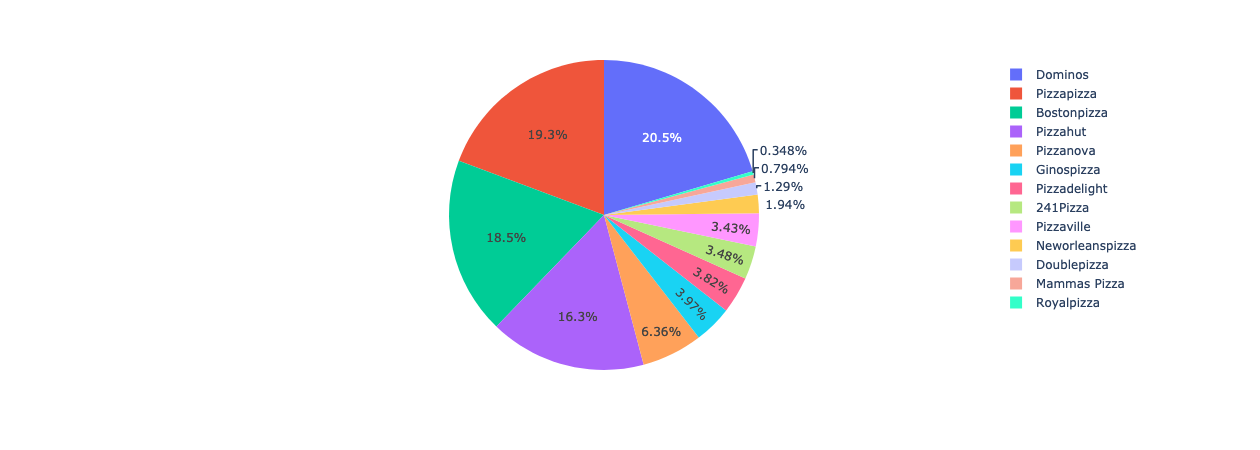

In [35]:
# some quick visualization
import plotly.express as px

px.pie(by_chain, values='shops', names='name')

For regional/provincial pie charts, let's add some interactivity through `ipywidgets` from the [last session](10-bridging-web-ui-to-notebook.ipynb):

In [36]:
import ipywidgets as widgets

regions = by_region_chain.region.unique().tolist()

def regional_pie(index):
    fig = px.pie(by_region_chain[by_region_chain['region'] == index], values='shops', names='name')

    return fig.show()


t = widgets.interact(
    regional_pie,
    index=widgets.ToggleButtons(
        options=regions,
        description='Province',
    ),
)

interactive(children=(ToggleButtons(description='Province', options=('AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'NT',…

## Remarks

Including a bit of SQL adds to the usage flexibility and, for some, a matter of preference. A SQL database also enables a more versatile and collaborative data analysis environment (especially a proper server-side solution such as Postgres). Data engineers and analysts can work with the data and then persist them to the SQL database. Then, software developers and engineers can access the same data on the front end through a completely different stack (often designed to be lighter than tools such as the Pandas library) to serve the end-users. And across the pipeline, all ends get to benefit from the built-in versatility of SQL itself to make some "last-mile data massaging."

Whether it's for preference, flexibility, or practical measures, adding a SQL solution to our toolbelt of data analysis is never a bad idea.

## References

* SQLite [official website](https://sqlite.org/index.html)
* [Python `sqlite3` module documentation](https://docs.python.org/3/library/sqlite3.html)
* Pandas' own [comparison with SQL](https://pandas.pydata.org/pandas-docs/stable/getting_started/comparison/comparison_with_sql.html), and the documentation on its `read_sql()` and `DataFrame/Series.to_sql()` interfaces.